In [69]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [70]:
#!pip install xgboost

In [71]:
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#from xgboost import XGBClassifier


In [72]:
x_train = pd.read_csv('https://raw.githubusercontent.com/jjbl99/waterpump/master/xtrain_clean.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/jjbl99/waterpump/master/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')
x_test = pd.read_csv('https://raw.githubusercontent.com/jjbl99/waterpump/master/xtest_clean.csv')

In [73]:
# Turn all data types into categorical data types
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): 
            df[n] = pd.factorize(df[n])[0]
    return df

In [74]:
x_train = train_cats(x_train)
x_test = train_cats(x_test)

In [75]:
y_num = y_train.replace(['functional','non functional', 'functional needs repair'], [0,1,2]) # replace labels by numerical values


In [76]:
x_train.drop('id', axis = 1, inplace = True)
y_train.drop('id', axis = 1, inplace = True)
x_test.drop('id', axis = 1, inplace = True)

In [77]:
xtrain, xvalid, ytrain, yvalid = train_test_split(x_train, y_num, test_size=0.2)

In [78]:
xtrain.head()

,Unnamed: 0,gps_height,longitude,latitude,num_private,basin,public_meeting,scheme_management,construction_year,extraction_type,...,quality_group,quantity,source,source_class,waterpoint_type,year_recorded,date_recordedMonth,date_recordedElapsed,population_log,age
25493,25493,1136.000000,37.04,-3.276494,0,2,1,5,2003.0,0,...,0,0,0,0,0,2013,3,810,0.693147,10.0
44782,44782,1501.181818,33.82,-3.430348,0,4,1,0,2004.0,2,...,0,2,5,0,2,2012,10,655,0.693147,8.0
34208,34208,197.000000,39.85,-10.642394,0,3,1,0,2012.0,7,...,1,0,3,0,1,2013,2,779,6.042633,1.0
32624,32624,1969.000000,34.24,-9.367719,0,0,1,0,2000.0,0,...,0,0,0,0,0,2011,2,54,5.017280,11.0
15806,15806,259.000000,36.93,-7.726233,0,7,1,8,2007.0,0,...,0,1,6,1,0,2011,3,66,5.303305,4.0


# Feature Selection

In [79]:
#I ran the feature selection apriori since it's easier to remove things from a panda array than a np matrix 

#x_train.drop(['year_recorded','source_class','date_recordedMonth','public_meeting','basin','payment_type','water_quality'], axis = 1, inplace = True)
#x_test.drop(['year_recorded','source_class','date_recordedMonth','public_meeting','basin','payment_type','water_quality'], axis = 1, inplace = True)

In [80]:
xtrain, xvalid, ytrain, yvalid = train_test_split(x_train, y_num, test_size=0.2)
ytrain.drop('id', axis = 1, inplace = True)
yvalid.drop('id', axis = 1, inplace = True)
xtrain.drop('Unnamed: 0', axis = 1, inplace = True)
xvalid.drop('Unnamed: 0', axis = 1, inplace = True)
scaler = StandardScaler()
feature_list = xtrain.columns

xtrain_FS = xtrain
xvalid_FS = xvalid

xtrain_PCA = xtrain
xvalid_PCA = xvalid

# Fit on training set only.
scaler.fit(xtrain)

# Apply transform to both the training set and the test set.
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)


Training accuracy:  0.9822390572390572
Validation accuracy:  0.7933501683501684


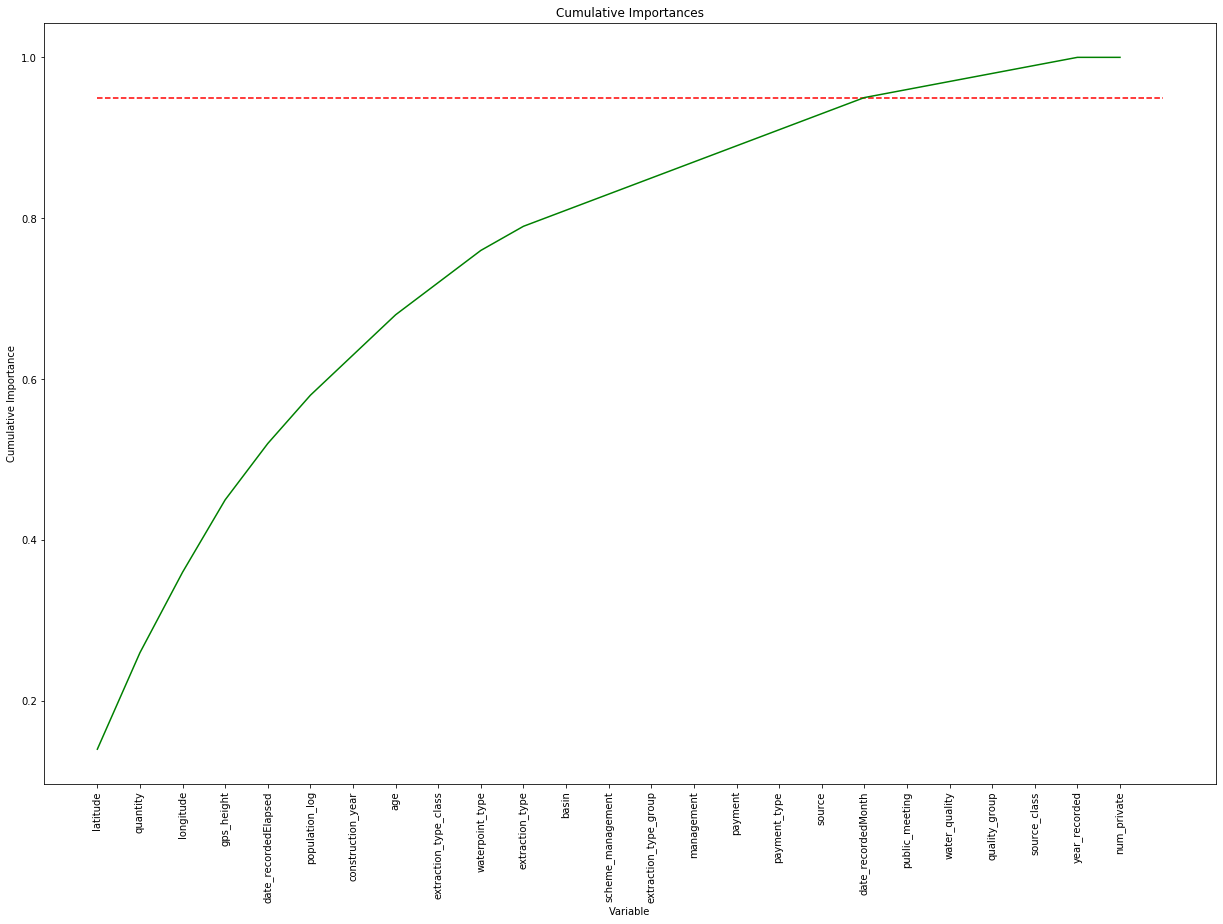

In [81]:
rf = RandomForestClassifier(max_depth=100).fit(xtrain,ytrain)
pred2 = rf.predict(xvalid)

print('Training accuracy: ', accuracy_score(ytrain, rf.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred2))
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# list of x locations for plotting
x_values = list(range(len(importances)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.figure(figsize=(21,14))
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

plt.show()

#this plot is no longer relevant since its using already reduced features

In [82]:
xvalid_FS.drop(['date_recordedMonth','public_meeting','water_quality','quality_group','source_class','year_recorded','num_private'], axis = 1, inplace = True)
xtrain_FS.drop(['year_recorded','source_class','date_recordedMonth','public_meeting','water_quality','quality_group','num_private'], axis = 1, inplace = True)

# PCA

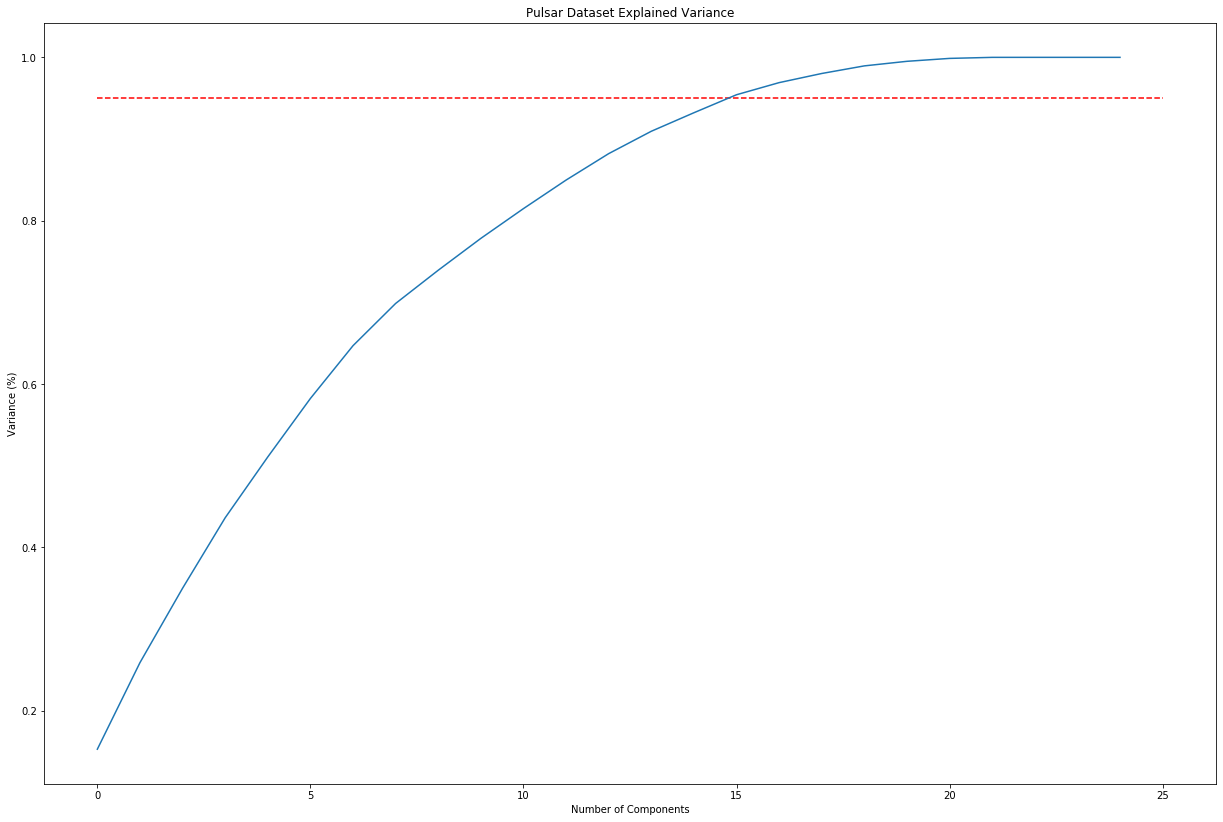

In [83]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(xtrain)

# Apply transform to both the training set and the test set.
#xtrain = scaler.transform(xtrain)
#xvalid = scaler.transform(xvalid)

#Fitting the PCA algorithm with our Data
pca1 = PCA().fit(xtrain)

#Plotting the Cumulative Summation of the Explained Variance

plt.figure(figsize=(21,14))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.hlines(y = 0.95, xmin=0, xmax= 25,color = 'r', linestyles = 'dashed')

plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')

plt.show()

In [84]:
#fit model with optimal components (90% variance kept)
pca = PCA(n_components= 15)
pca.fit(xtrain) 

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  

xvalid_PCA = pca.transform(xvalid)
xtrain_PCA = pca.transform(xtrain)
#x_test_PCA = pca.transform(x_test)

[0.15305177 0.10596362 0.09107611 0.08626898 0.07448395 0.07155512
 0.06461371 0.05169698 0.04067502 0.03900887 0.03643511 0.03492581
 0.03237398 0.02737774 0.02267873]


# Decision Tree Classifier

In [85]:
#with PCA
dtc_PCA = DecisionTreeClassifier(max_depth=5).fit(xtrain_PCA, ytrain)
pred1_PCA = dtc_PCA.predict(xvalid_PCA)

In [86]:
print('Training accuracy: ', accuracy_score(ytrain, dtc_PCA.predict(xtrain_PCA)))
print('Validation accuracy: ', accuracy_score(yvalid, pred1_PCA))

Training accuracy:  0.6798190235690236
Validation accuracy:  0.6759259259259259


In [88]:

pc1 = metrics.classification_report(yvalid, pred1_PCA, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred1_PCA, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.660     0.887     0.757      6526
         non functional      0.721     0.496     0.588      4509
functional needs repair      0.667     0.007     0.014       845

               accuracy                          0.676     11880
              macro avg      0.683     0.463     0.453     11880
           weighted avg      0.684     0.676     0.640     11880



In [90]:
#with FS
dtc_FS = DecisionTreeClassifier(max_depth=5).fit(xtrain_FS, ytrain)
pred1_FS = dtc_FS.predict(xvalid_FS)

In [91]:
print('Training accuracy: ', accuracy_score(ytrain, dtc_FS.predict(xtrain_FS)))
print('Validation accuracy: ', accuracy_score(yvalid, pred1_FS))

Training accuracy:  0.7065656565656566
Validation accuracy:  0.7142255892255892


In [92]:

fs1 = metrics.classification_report(yvalid, pred1_FS, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred1_FS, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.666     0.973     0.791      6526
         non functional      0.910     0.473     0.622      4509
functional needs repair      0.000     0.000     0.000       845

               accuracy                          0.714     11880
              macro avg      0.525     0.482     0.471     11880
           weighted avg      0.711     0.714     0.671     11880



# Random Forest Classifier

In [93]:
rf_PCA = RandomForestClassifier(max_depth=100).fit(xtrain_PCA,ytrain)
pred2_PCA = rf_PCA.predict(xvalid_PCA)

In [94]:
print('Training accuracy: ', accuracy_score(ytrain, rf_PCA.predict(xtrain_PCA)))
print('Validation accuracy: ', accuracy_score(yvalid, pred2_PCA))

Training accuracy:  0.9809974747474748
Validation accuracy:  0.7678451178451179


In [100]:

pc2 = metrics.classification_report(yvalid, pred2_PCA, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred2_PCA, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.780     0.850     0.814      6526
         non functional      0.783     0.741     0.761      4509
functional needs repair      0.467     0.282     0.351       845

               accuracy                          0.768     11880
              macro avg      0.677     0.624     0.642     11880
           weighted avg      0.759     0.768     0.761     11880



In [101]:
rf_FS = RandomForestClassifier(max_depth=100).fit(xtrain_FS,ytrain)
pred2_FS = rf_FS.predict(xvalid_FS)

print('Training accuracy: ', accuracy_score(ytrain, rf_FS.predict(xtrain_FS)))
print('Validation accuracy: ', accuracy_score(yvalid, pred2_FS))

Training accuracy:  0.981712962962963
Validation accuracy:  0.7902356902356902


In [102]:

fs2 = metrics.classification_report(yvalid, pred2_FS, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred2_FS, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.796     0.871     0.832      6526
         non functional      0.818     0.765     0.791      4509
functional needs repair      0.484     0.301     0.371       845

               accuracy                          0.790     11880
              macro avg      0.699     0.646     0.665     11880
           weighted avg      0.782     0.790     0.784     11880



# Support Vector Machine

In [103]:
svm = SVC().fit(xtrain_PCA,ytrain)
pred3 = svm.predict(xvalid_PCA)

In [104]:
print('Training accuracy: ', accuracy_score(ytrain, svm.predict(xtrain_PCA)))
print('Validation accuracy: ', accuracy_score(yvalid, pred3))

Training accuracy:  0.7586279461279462
Validation accuracy:  0.7446127946127946


In [105]:

pc3 = metrics.classification_report(yvalid, pred3, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred3, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.725     0.904     0.804      6526
         non functional      0.794     0.640     0.709      4509
functional needs repair      0.583     0.075     0.132       845

               accuracy                          0.745     11880
              macro avg      0.701     0.539     0.548     11880
           weighted avg      0.741     0.745     0.720     11880



In [106]:
svm = SVC().fit(xtrain_FS,ytrain)
pred3 = svm.predict(xvalid_FS)

In [107]:
print('Training accuracy: ', accuracy_score(ytrain, svm.predict(xtrain_FS)))
print('Validation accuracy: ', accuracy_score(yvalid, pred3))

Training accuracy:  0.9191077441077441
Validation accuracy:  0.6823232323232323


In [108]:

fs3 = metrics.classification_report(yvalid, pred3, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred3, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.667     0.890     0.763      6526
         non functional      0.742     0.480     0.583      4509
functional needs repair      0.517     0.159     0.243       845

               accuracy                          0.682     11880
              macro avg      0.642     0.509     0.529     11880
           weighted avg      0.685     0.682     0.657     11880



# SGD

In [109]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [110]:
sgd = SGDClassifier(loss="hinge", penalty="l2").fit(xtrain,ytrain)
pred4 = sgd.predict(xvalid)

In [111]:
print('Training accuracy: ', accuracy_score(ytrain, sgd.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred4))

Training accuracy:  0.569486531986532
Validation accuracy:  0.5743265993265994


In [112]:

fs4 = metrics.classification_report(yvalid, pred4, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred4, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.578     0.951     0.719      6526
         non functional      0.785     0.127     0.219      4509
functional needs repair      0.097     0.047     0.064       845

               accuracy                          0.574     11880
              macro avg      0.487     0.375     0.334     11880
           weighted avg      0.623     0.574     0.483     11880



In [113]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA

In [114]:
sgd = SGDClassifier(loss="hinge", penalty="l2").fit(xtrain,ytrain)
pred4 = sgd.predict(xvalid)

In [115]:
print('Training accuracy: ', accuracy_score(ytrain, sgd.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred4))

Training accuracy:  0.6334806397306397
Validation accuracy:  0.6364478114478115


In [116]:

pc4 = metrics.classification_report(yvalid, pred4, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred4, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.657     0.779     0.713      6526
         non functional      0.598     0.550     0.573      4509
functional needs repair      0.000     0.000     0.000       845

               accuracy                          0.636     11880
              macro avg      0.418     0.443     0.429     11880
           weighted avg      0.588     0.636     0.609     11880



# KNN

In [117]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [118]:
knn = KNeighborsClassifier(n_neighbors=7).fit(xtrain,ytrain)
pred5 = knn.predict(xvalid)

In [119]:
print('Training accuracy: ', accuracy_score(ytrain, knn.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred5))

Training accuracy:  0.7516624579124579
Validation accuracy:  0.6777777777777778


In [120]:

fs5 = metrics.classification_report(yvalid, pred5, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred5, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.698     0.801     0.746      6526
         non functional      0.664     0.591     0.625      4509
functional needs repair      0.420     0.188     0.260       845

               accuracy                          0.678     11880
              macro avg      0.594     0.527     0.544     11880
           weighted avg      0.665     0.678     0.666     11880



In [121]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA

In [122]:
knn = KNeighborsClassifier(n_neighbors=7).fit(xtrain,ytrain)
pred5 = knn.predict(xvalid)

In [123]:
print('Training accuracy: ', accuracy_score(ytrain, knn.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred5))

Training accuracy:  0.8098274410774411
Validation accuracy:  0.7567340067340067


In [124]:

pc5 = metrics.classification_report(yvalid, pred5, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred5, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.764     0.859     0.809      6526
         non functional      0.773     0.711     0.741      4509
functional needs repair      0.454     0.211     0.288       845

               accuracy                          0.757     11880
              macro avg      0.664     0.594     0.612     11880
           weighted avg      0.745     0.757     0.746     11880



# Naive Bayes

In [125]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [126]:
gnb = GaussianNB().fit(xtrain,ytrain)
pred6 = gnb.predict(xvalid)

In [127]:
print('Training accuracy: ', accuracy_score(ytrain, gnb.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred6))

Training accuracy:  0.609743265993266
Validation accuracy:  0.6096801346801347


In [128]:

fs6 = metrics.classification_report(yvalid, pred6, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred6, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.671     0.684     0.677      6526
         non functional      0.564     0.592     0.577      4509
functional needs repair      0.226     0.134     0.168       845

               accuracy                          0.610     11880
              macro avg      0.487     0.470     0.474     11880
           weighted avg      0.599     0.610     0.603     11880



In [129]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA

In [130]:
gnb = GaussianNB().fit(xtrain,ytrain)
pred6 = gnb.predict(xvalid)

In [131]:
print('Training accuracy: ', accuracy_score(ytrain, gnb.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred6))

Training accuracy:  0.6158459595959596
Validation accuracy:  0.6196969696969697


In [132]:

pc6 =metrics.classification_report(yvalid, pred6, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred6, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.672     0.702     0.687      6526
         non functional      0.560     0.607     0.582      4509
functional needs repair      0.263     0.054     0.090       845

               accuracy                          0.620     11880
              macro avg      0.498     0.454     0.453     11880
           weighted avg      0.600     0.620     0.605     11880



# Neural Network

In [133]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [134]:
mlp = MLPClassifier().fit(xtrain,ytrain)
pred7 = mlp.predict(xvalid)

In [135]:
print('Training accuracy: ', accuracy_score(ytrain, mlp.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred7))

Training accuracy:  0.4119318181818182
Validation accuracy:  0.4047979797979798


In [136]:

fs7 =metrics.classification_report(yvalid, pred7, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred7, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.774     0.182     0.295      6526
         non functional      0.468     0.712     0.565      4509
functional needs repair      0.117     0.485     0.189       845

               accuracy                          0.405     11880
              macro avg      0.453     0.460     0.350     11880
           weighted avg      0.611     0.405     0.390     11880



In [137]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA

In [138]:
mlp = MLPClassifier().fit(xtrain,ytrain)
pred7 = mlp.predict(xvalid)

In [139]:
print('Training accuracy: ', accuracy_score(ytrain, mlp.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred7))

Training accuracy:  0.7640782828282828
Validation accuracy:  0.7422558922558923


In [140]:

pc7 =metrics.classification_report(yvalid, pred7, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, pred7, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

                         precision    recall  f1-score   support

             functional      0.751     0.849     0.797      6526
         non functional      0.742     0.704     0.722      4509
functional needs repair      0.466     0.122     0.193       845

               accuracy                          0.742     11880
              macro avg      0.653     0.558     0.571     11880
           weighted avg      0.727     0.742     0.726     11880



# Extremely Randomized Trees

In [ ]:
xtrain, xvalid = xtrain_FS, xvalid_FS
etc = ExtraTreesClassifier(n_estimators=300, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=95)
etc.fit(xtrain,ytrain)
predetc = etc.predict(xvalid)


In [ ]:
print('Training accuracy: ', accuracy_score(ytrain, etc.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predetc))

In [ ]:

metrics.classification_report(yvalid, predetc, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=True)
print(metrics.classification_report(yvalid, predetc, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False))

# XGBoost

In [ ]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA
#TODO perform grid search to find best hyperparameters (this has potential)
xgb = XGBClassifier(max_depth=9, n_estimators=300,
       objective='multi:softmax') #can also use softprob for multiclass
xgb.fit(xtrain,ytrain)
trainxgb = xgb.predict(xtrain)
predxgb = xgb.predict(xvalid)

In [ ]:
#ytrain.drop('id', axis = 1, inplace = True)
#yvalid.drop('id', axis = 1, inplace = True)

In [ ]:
print('Training accuracy: ', accuracy_score(ytrain, trainxgb))
print('Validation accuracy: ', accuracy_score(yvalid, predxgb))

In [ ]:
xtrain, xvalid = xtrain_FS, xvalid_FS
#TODO perform grid search to find best hyperparameters (this has potential)
xgb = XGBClassifier(max_depth=9, n_estimators=300,
       objective='multi:softmax') #can also use softprob for multiclass
xgb.fit(xtrain,ytrain)
trainxgb = xgb.predict(xtrain)
predxgb = xgb.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, trainxgb))
print('Validation accuracy: ', accuracy_score(yvalid, predxgb))

## Vanilla Results

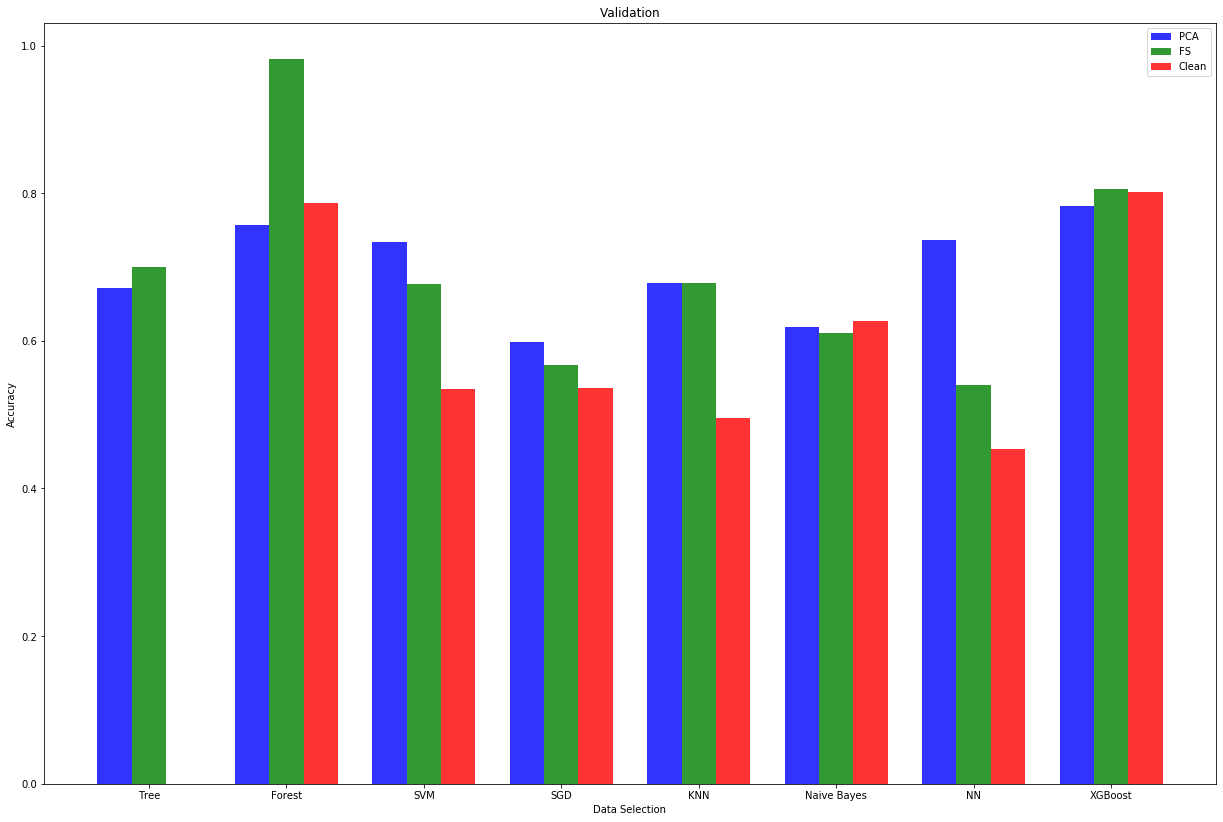

<Figure size 1512x1008 with 0 Axes>

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 8
pca_val = (0.671885521886,0.757070707071,0.73367003367,0.598400673401,0.67803030303,0.61835016835, 0.737121212121, 0.7832
          )
fs_val = (0.700252525253,0.981755050505,0.676515151515,0.567255892256,0.67803030303,0.610858585859,0.540656565657,.8055)

first_val= (0,0.7871212121212121,0.5353535353535354,0.5361111111111111,0.49595959595959593,0.6266835016835017,0.4535353535353535,0.801)


# create plot

fig, ax = plt.subplots(figsize=(21,14))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, pca_val, bar_width,
alpha=opacity,
color='b',
label='PCA')

rects2 = plt.bar(index + bar_width, fs_val, bar_width,
alpha=opacity,
color='g',
label='FS')

rects3 = plt.bar(index + 2*bar_width, first_val, bar_width,
alpha=opacity,
color='r',
label='Clean')

plt.xlabel('Data Selection')
plt.ylabel('Accuracy')
plt.title('Validation')
plt.xticks(index + bar_width,  ('Tree','Forest','SVM',"SGD",'KNN','Naive Bayes',"NN","XGBoost"))
plt.legend()
plt.figure(figsize=(21,14))
plt.show()

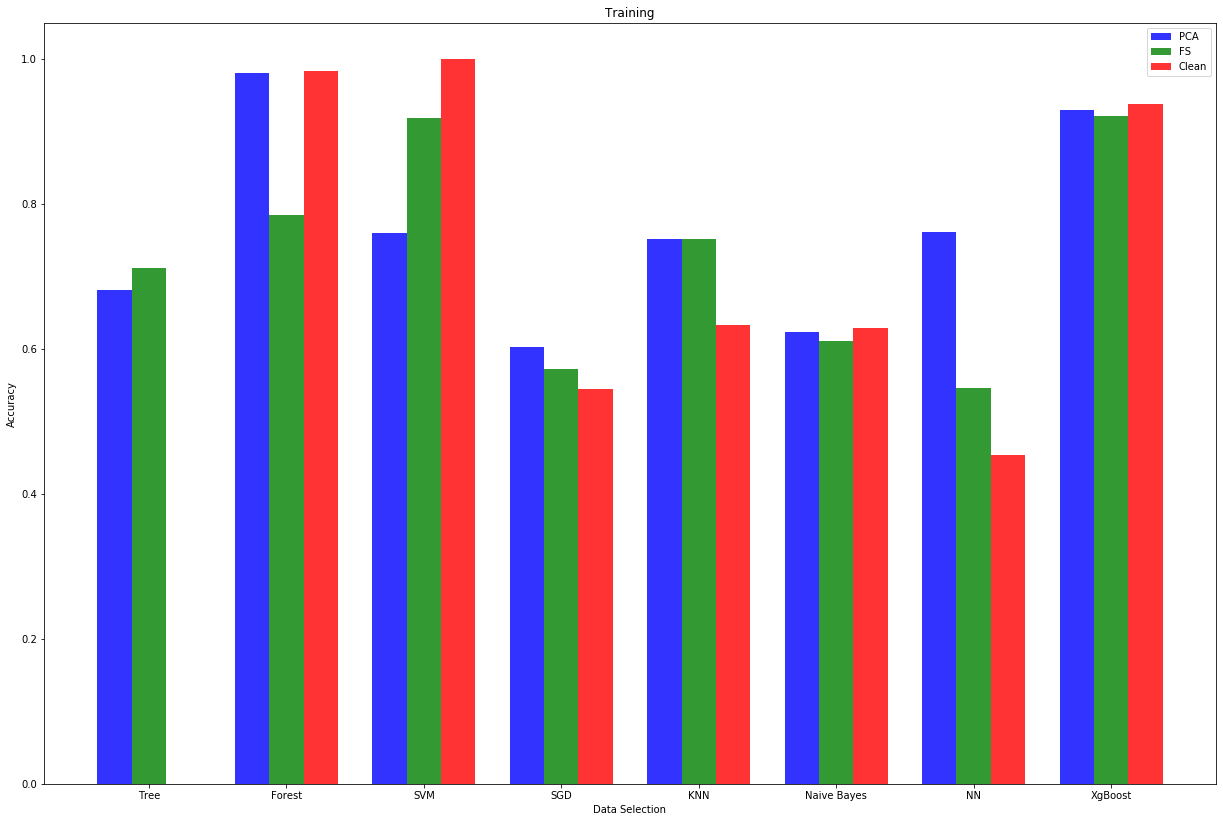

<Figure size 1512x1008 with 0 Axes>

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot this is for training - to lazy to relabel stuff but changed data 

n_groups = 8
pca_val = (0.681102693603,0.981334175084,0.759301346801,0.60281986532,0.752272727273, 0.623800505051,0.761784511785,0.929313)
fs_val = (0.711195286195,0.784764309764,0.918434343434,0.572306397306,0.752272727273,0.610353535354,0.546506734007,0.9219 )

first_val= (0,0.9840488215488216,1.0,0.54503367003367,0.6333122895622896,0.6289772727272728,0.4540824915824916,.9380)


# create plot
fig, ax = plt.subplots(figsize=(21,14))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, pca_val, bar_width,
alpha=opacity,
color='b',
label='PCA')

rects2 = plt.bar(index + bar_width, fs_val, bar_width,
alpha=opacity,
color='g',
label='FS')

rects3 = plt.bar(index + 2*bar_width, first_val, bar_width,
alpha=opacity,
color='r',
label='Clean')

plt.xlabel('Data Selection')
plt.ylabel('Accuracy')
plt.title('Training')
plt.xticks(index + bar_width,  ('Tree','Forest','SVM',"SGD",'KNN','Naive Bayes',"NN","XgBoost"))
plt.legend()
plt.figure(figsize=(21,14))
plt.show()

## Accuracy Comparison

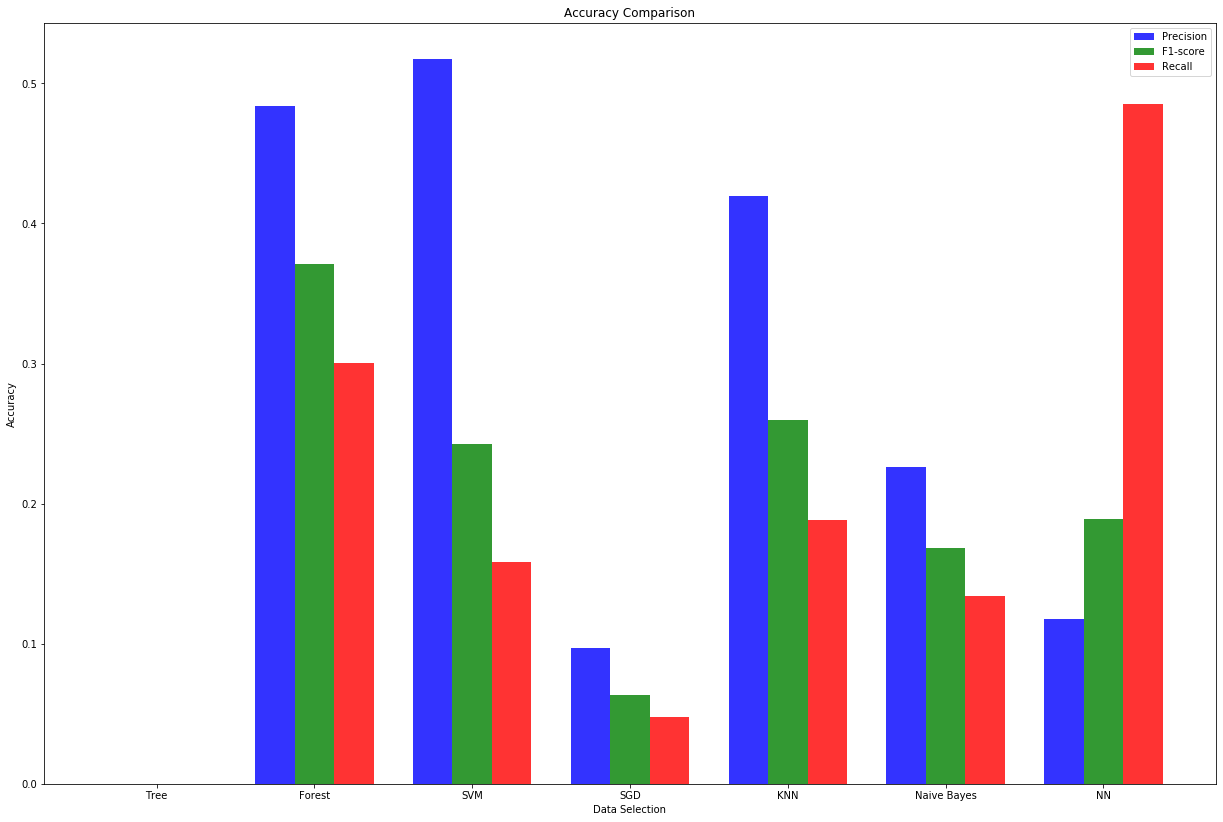

<Figure size 1512x1008 with 0 Axes>

In [143]:
pclist = [pc1,pc2,pc3,pc4,pc5,pc6,pc7]
fslist = [fs1,fs2,fs3,fs4,fs5,fs6,fs7]

pcpres = [item['functional needs repair']['precision'] for item in pclist]
pcf = [item['functional needs repair']['f1-score'] for item in pclist]


n_groups = 7

fsp = [item['functional needs repair']['precision'] for item in fslist]
fsf = [item['functional needs repair']['f1-score'] for item in fslist]
fsr = [item['functional needs repair']['recall'] for item in fslist]

# create plot
fig, ax = plt.subplots(figsize=(21,14))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, fsp, bar_width,
alpha=opacity,
color='b',
label='Precision')

rects2 = plt.bar(index + bar_width, fsf, bar_width,
alpha=opacity,
color='g',
label='F1-score')

rects3 = plt.bar(index + 2*bar_width, fsr, bar_width,
alpha=opacity,
color='r',
label='Recall')

plt.xlabel('Data Selection')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(index + bar_width,  ('Tree','Forest','SVM',"SGD",'KNN','Naive Bayes',"NN","XgBoost"))
plt.legend()
plt.figure(figsize=(21,14))
plt.show()

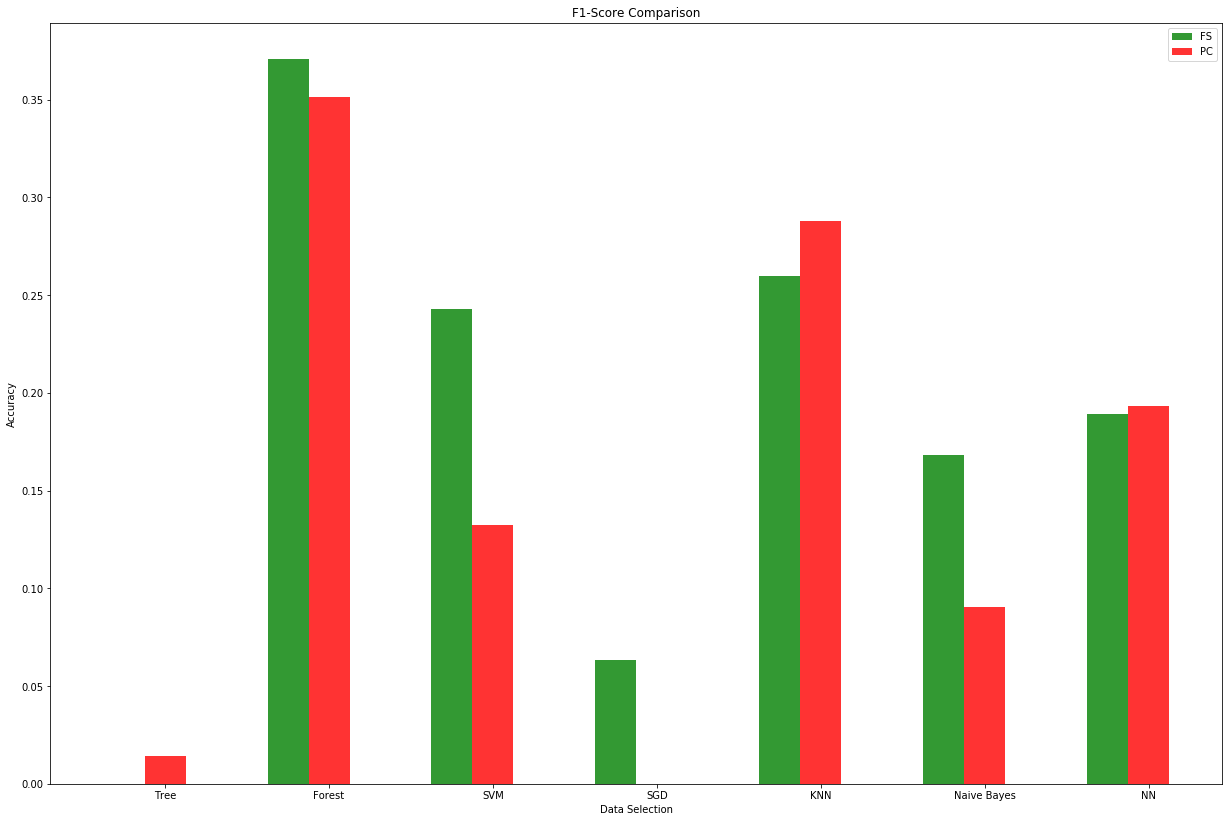

<Figure size 1512x1008 with 0 Axes>

In [146]:
pclist = [pc1,pc2,pc3,pc4,pc5,pc6,pc7] #list of dictionaries containing relevant information
fslist = [fs1,fs2,fs3,fs4,fs5,fs6,fs7]

pcpres = [item['functional needs repair']['precision'] for item in pclist]
pcf = [item['functional needs repair']['f1-score'] for item in pclist]


n_groups = 7


fsf = [item['functional needs repair']['f1-score'] for item in fslist]
pcf = [item['functional needs repair']['f1-score'] for item in pclist]

# create plot
fig, ax = plt.subplots(figsize=(21,14))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8


rects2 = plt.bar(index, fsf, bar_width,
alpha=opacity,
color='g',
label='FS')

rects3 = plt.bar(index + bar_width, pcf, bar_width,
alpha=opacity,
color='r',
label='PC')

plt.xlabel('Data Selection')
plt.ylabel('Accuracy')
plt.title('F1-Score Comparison')
plt.xticks(index + bar_width,  ('Tree','Forest','SVM',"SGD",'KNN','Naive Bayes',"NN","XgBoost"))
plt.legend()
plt.figure(figsize=(21,14))
plt.show()

# Optimizing the Random Forest

In [ ]:
param_grid = { 
    'n_estimators': [300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,30,50],
    'criterion' :['gini', 'entropy']
}

In [ ]:
gridRF.best_params_

In [ ]:
gridRF = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)
gridRF.fit(xtrain, ytrain)

In [ ]:
rf1 = RandomForestClassifier(max_depth=30, criterion = 'gini', max_features='sqrt', n_estimators=500).fit(xtrain,ytrain)
predrf1 = rf1.predict(xvalid)

In [ ]:
print('Training accuracy: ', accuracy_score(ytrain, rf1.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predrf1))

In [ ]:
rf2 = RandomForestClassifier(max_depth=30, criterion = 'gini', max_features='sqrt', n_estimators=700).fit(xtrain,ytrain)
predrf2 = rf2.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, rf2.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predrf2))


In [43]:
rf3 = RandomForestClassifier(n_estimators=300, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=95)
rf3.fit(xtrain,ytrain)
trainrf3 = rf3.predict(xtrain)
predrf3 = rf3.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, trainrf3))
print('Validation accuracy: ', accuracy_score(yvalid, predrf3))

Training accuracy:  0.926473063973064
Validation accuracy:  0.8078282828282828


# XG Boost parameter tuning

In [ ]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [ ]:
param_test1 = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(xtrain, ytrain.values.ravel())
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
rf1 = RandomForestClassifier(max_depth=30, criterion = 'gini', max_features='sqrt', n_estimators=500).fit(xtrain,ytrain)
predrf1 = rf1.predict(xvalid)

In [ ]:
print('Training accuracy: ', accuracy_score(ytrain, rf1.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predrf1))

In [ ]:
rf2 = RandomForestClassifier(max_depth=30, criterion = 'gini', max_features='sqrt', n_estimators=700).fit(xtrain,ytrain)
predrf2 = rf2.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, rf2.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predrf2))


In [ ]:
rf3 = RandomForestClassifier(n_estimators=300, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=95)
rf3.fit(xtrain,ytrain)
trainrf3 = rf3.predict(xtrain)
predrf3 = rf3.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, trainrf3))
print('Validation accuracy: ', accuracy_score(yvalid, predrf3))

# Stacking our best two models

TODO: code own stacker thing
plot correlation of two models (more uncorrelated is better askip)

In [ ]:
stacker = LogisticRegression()
twotrain = pd.concat([pd.Series(trainrf3),pd.Series(trainxgb)], axis = 1)
twopred = pd.concat([pd.Series(predrf3),pd.Series(predxgb)], axis = 1)

stacker.fit(twotrain, ytrain)

In [ ]:
stackerpred = stacker.predict(twopred)

In [ ]:
print('Training accuracy: ', accuracy_score(ytrain, stacker.predict(twotrain)))
print('Validation accuracy: ', accuracy_score(yvalid, stackerpred))

In [ ]:
cm = confusion_matrix(predrf3,yvalid)

In [ ]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(cm)

In [ ]:
cm2 = confusion_matrix(predxgb,yvalid)

In [ ]:
print(cm2)

In [ ]:
twotrain.corr()

In [ ]:
twopred.corr()

## Improved Accuracy Measure

In [68]:
att = metrics.classification_report(yvalid, predrf3, labels=[0,1,2], target_names=['functional','non functional', 'functional needs repair'], sample_weight=None, digits=3, output_dict=False)


print(att)

                         precision    recall  f1-score   support

             functional      0.795     0.901     0.845      6400
         non functional      0.849     0.770     0.808      4657
functional needs repair      0.604     0.300     0.401       823

               accuracy                          0.808     11880
              macro avg      0.749     0.657     0.684     11880
           weighted avg      0.803     0.808     0.799     11880

